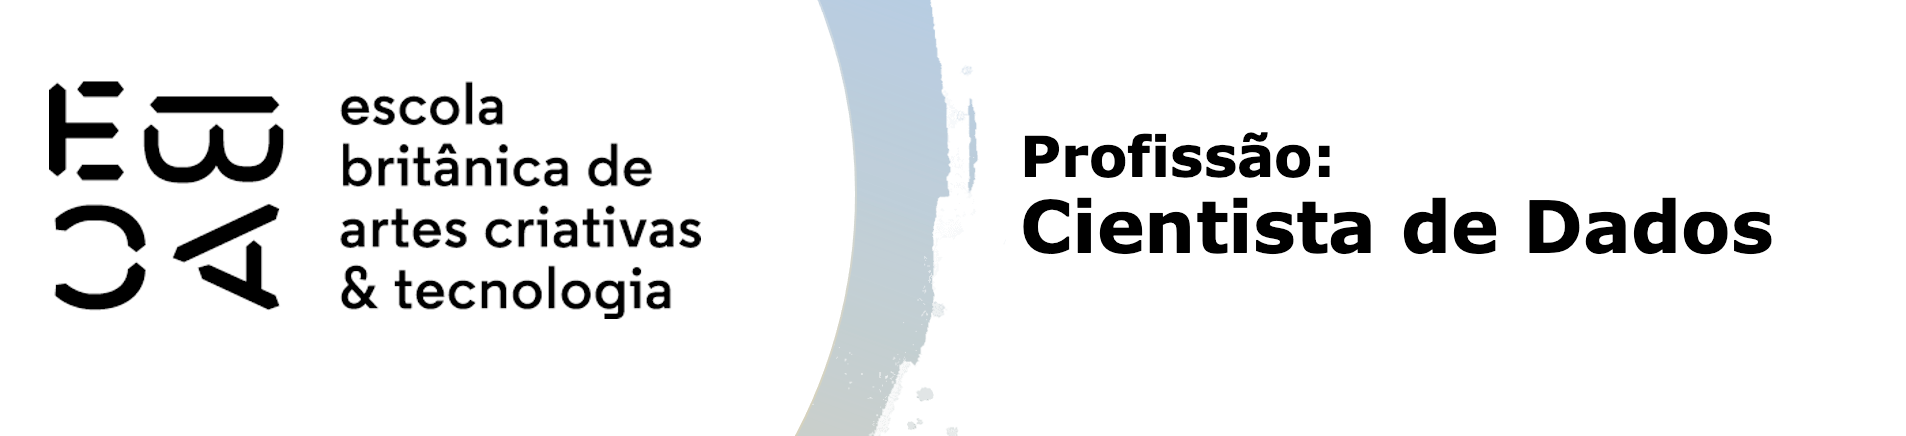

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [ ]:
import pandas as pd
from pandas.api.types import is_object_dtype
from pandas.api.types import is_bool_dtype


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from gower import gower_matrix

In [193]:
df = pd.read_csv('online_shoppers_intention.csv')

In [194]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

Verificação do tipo de cada variável:

In [195]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Função para verificar a distribuição das variáveis do DataFrame:

In [ ]:
def distribuicao (df: pd.DataFrame, var: str, limite_discretas=40):
    '''
    Recebe um DataFrame e uma variável:
    
    Devolve um histplot com um boxplot junto, diferenciando variável quantítativa contínua e discreta;
    
    Devolve um countplot para as variáveis qualitativas ou booleanas;
    '''
    
    if is_object_dtype(df[var]) or is_bool_dtype(df[var]):
        
        fig = plt.figure(figsize=(10,6))
        
        ordem = df[var].value_counts().index
        ax = sns.countplot(df, x=var, hue=var, palette='crest', order=ordem,legend=False)
        
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
        
        ax.set(title = f'Distribuição da Quantidade por {var.capitalize()}', ylabel = 'Quantidade', xlabel = var.capitalize())
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)

        plt.show()
        
    else:
        
        unicos = df[var].nunique()
        if unicos <= limite_discretas:
            tipo = 'discreta'
        else:
            tipo = 'contínua'
        
        fig = plt.figure(figsize=(10, 6))

        if tipo == 'contínua':       
            gs = fig.add_gridspec(2, 1, height_ratios=(1, 4), hspace=0.05)

            ax_box = fig.add_subplot(gs[0])
            ax_hist = fig.add_subplot(gs[1], sharex=ax_box)

            sns.boxplot(x=df[var], ax=ax_box, color= sns.color_palette('crest')[3])
            ax_box.set(title=f'Distribuição da variável contínua: {var}')
            ax_box.set_ylabel('BoxPlot', rotation=0, labelpad=20)
            ax_box.grid(True, linestyle='--', alpha=0.3)

            sns.histplot(df[var], bins=30, ax=ax_hist, color=sns.color_palette('crest')[3])
            ax_hist.set(ylabel='Contagem')
            ax_hist.grid(True, linestyle='--', alpha=0.3)

            ax_box.tick_params(axis='x', labelbottom=True)
            
        else:
            gs = fig.add_gridspec(2, 1, height_ratios=(1, 4), hspace=0.05)

            ax_box = fig.add_subplot(gs[0])
            ax_count = fig.add_subplot(gs[1], sharex=ax_box)

            sns.boxplot(x=df[var], ax=ax_box, color= sns.color_palette('crest')[0])
            ax_box.set(title=f'Distribuição da variável discreta: {var}')
            ax_box.set_ylabel('BoxPlot', rotation=0, labelpad=20)
            ax_box.grid(True, linestyle='--', alpha=0.3)


            sns.countplot(x=df[var], ax=ax_count, color= sns.color_palette('crest')[0], edgecolor='black')
            ax_count.set(ylabel='Contagem')
            ax_count.grid(True, linestyle='--', alpha=0.3)


            ax_box.tick_params(axis='x', labelbottom=True)
            
        plt.show()

Distribuição das variáveis do DataFrame:

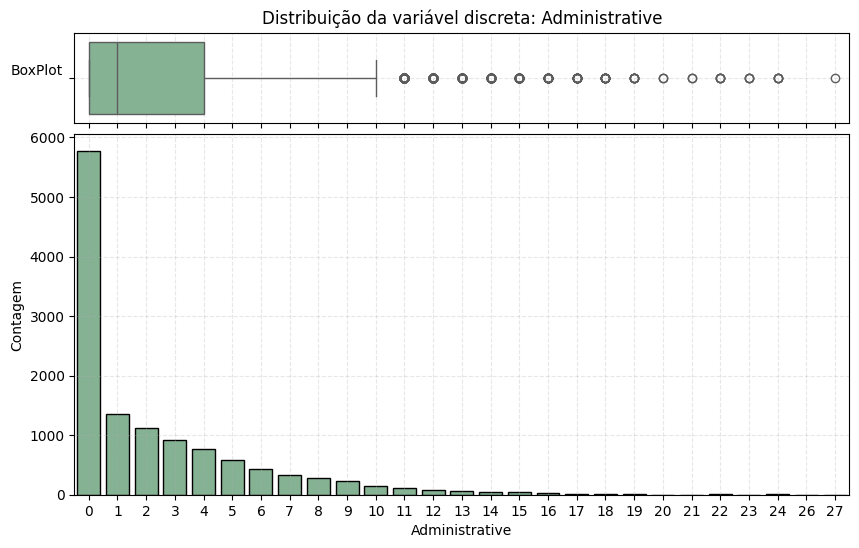

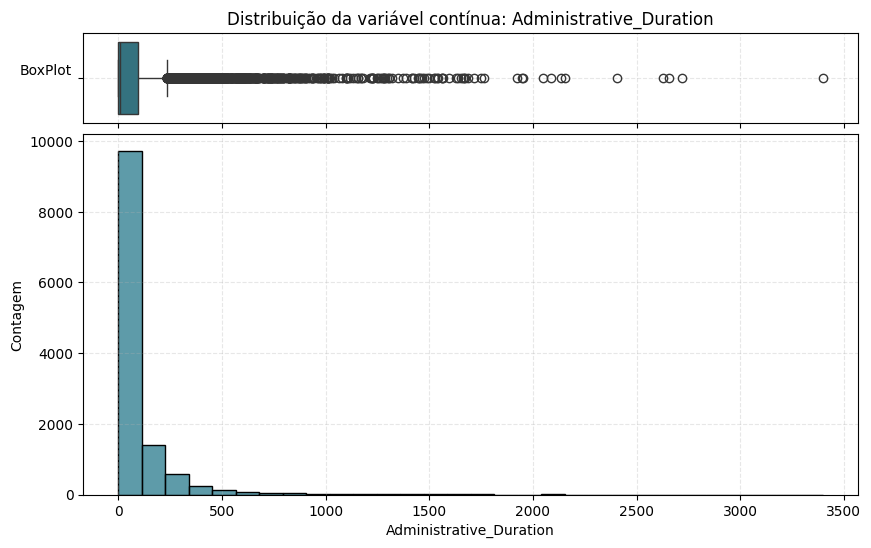

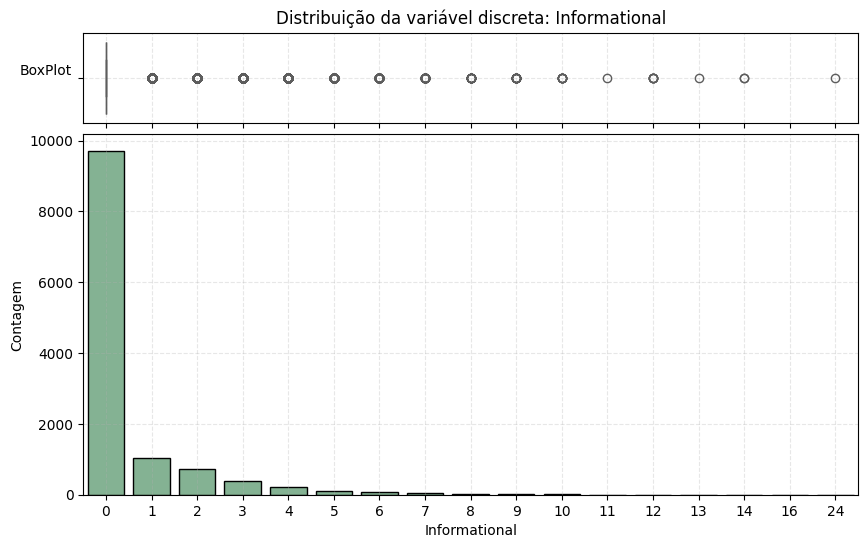

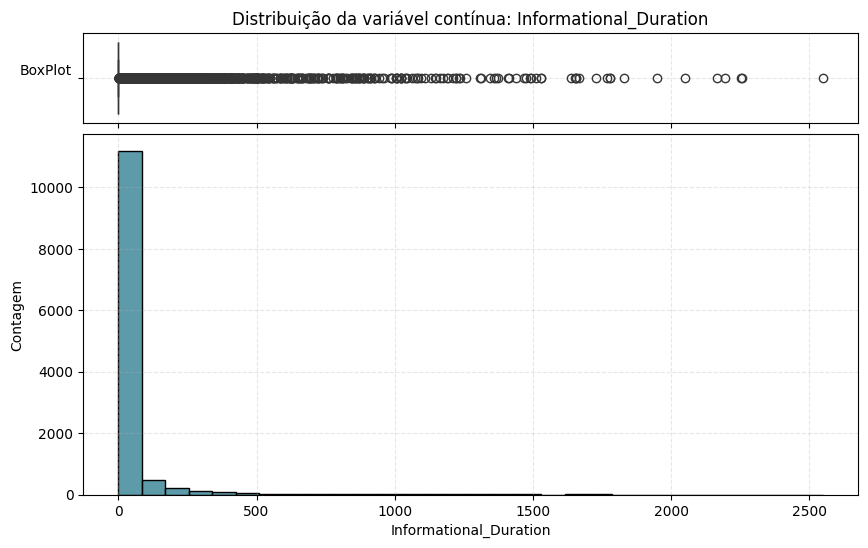

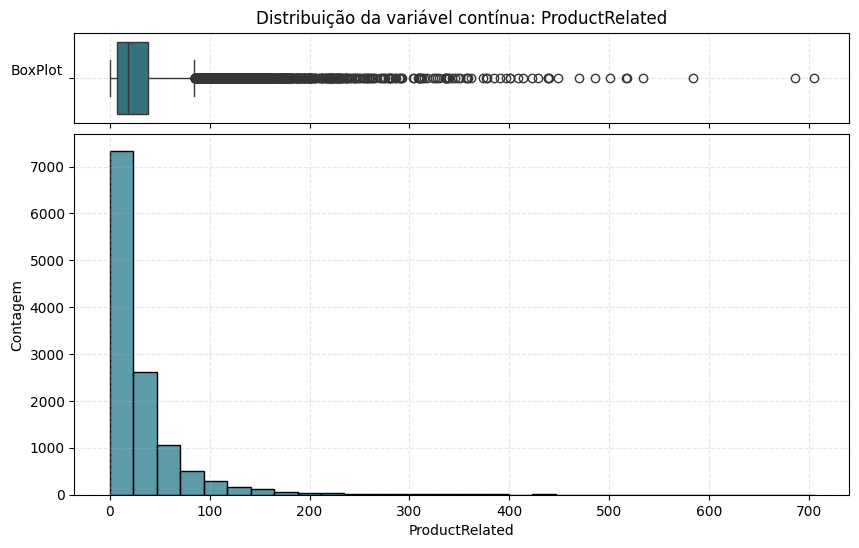

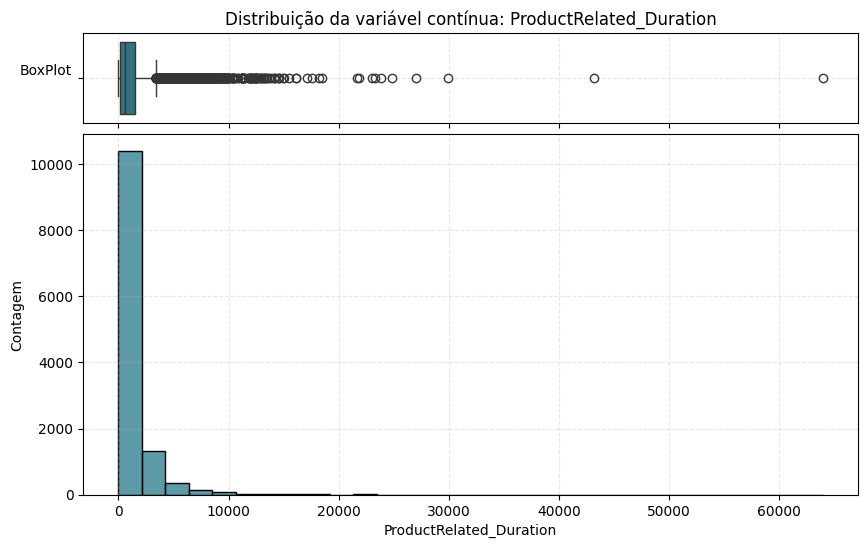

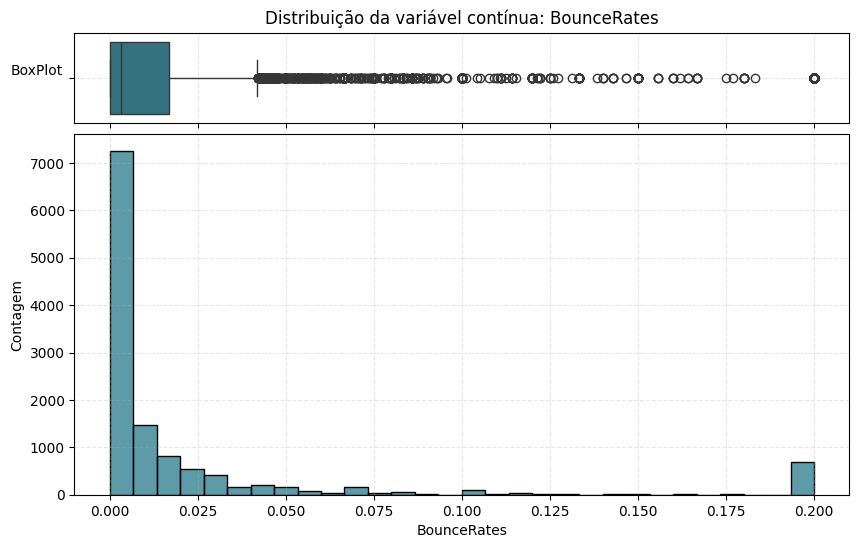

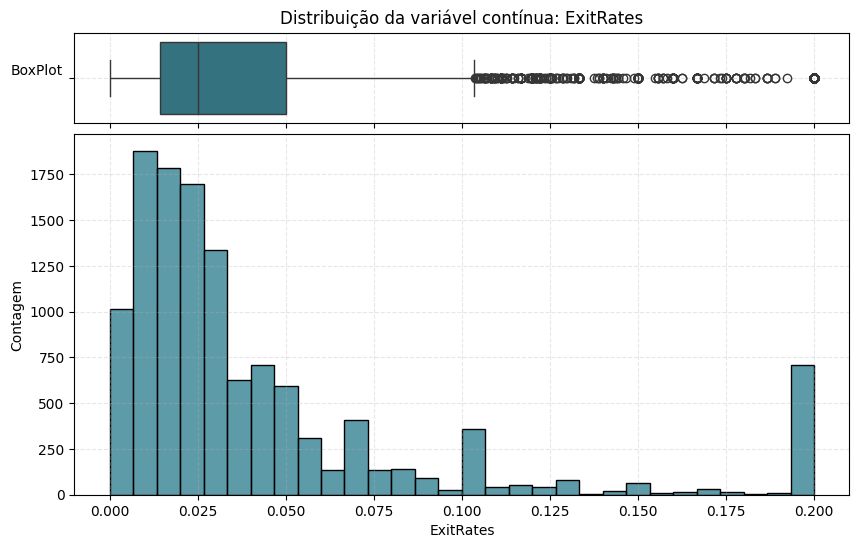

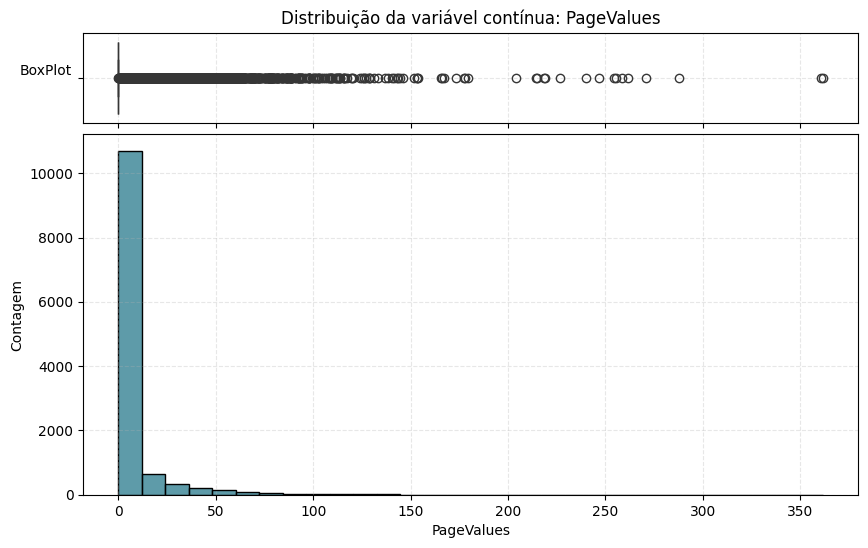

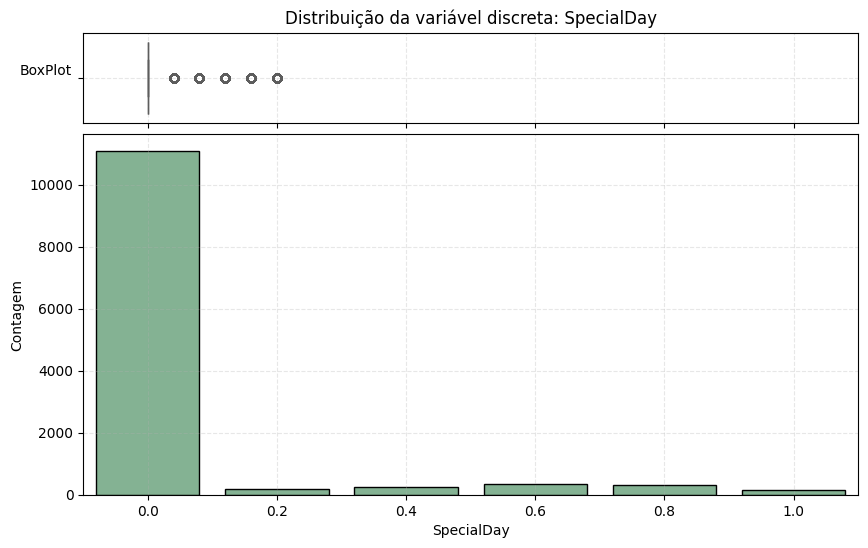

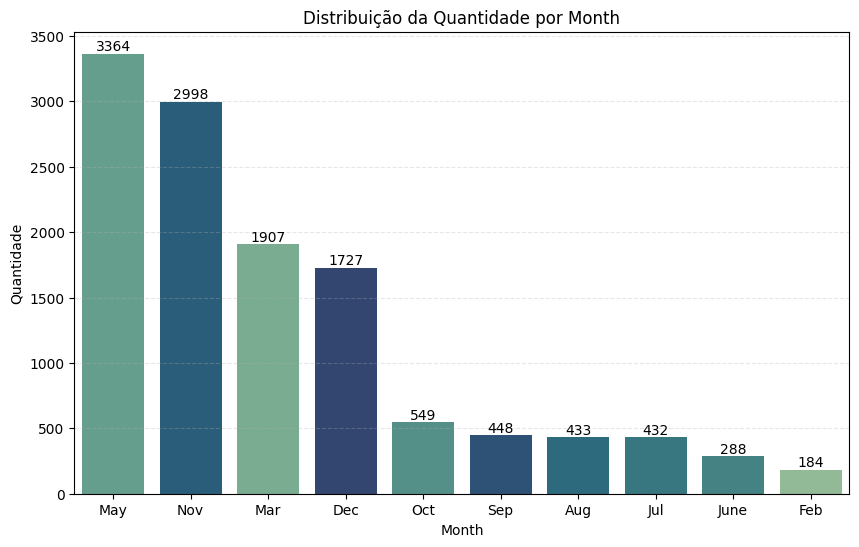

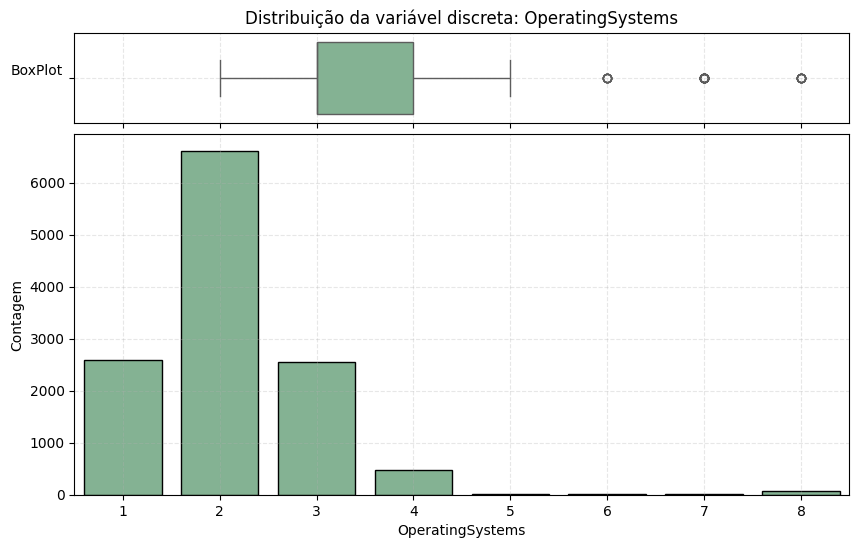

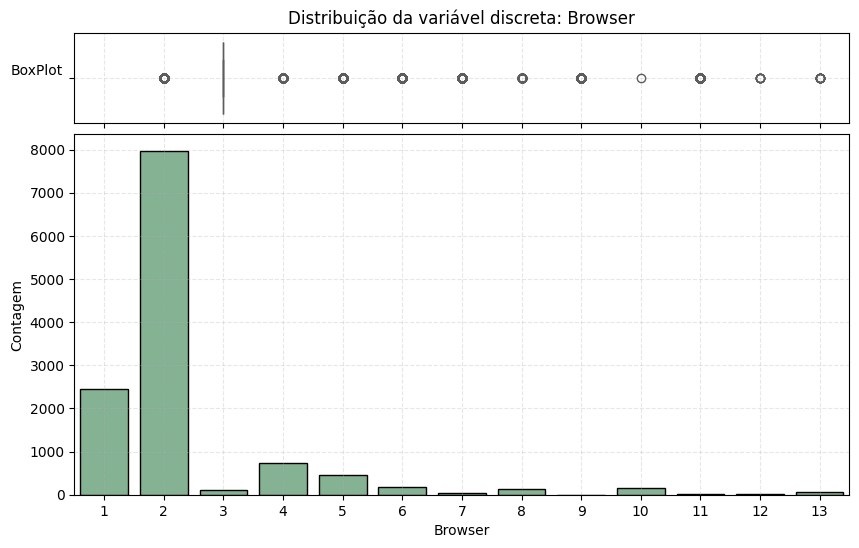

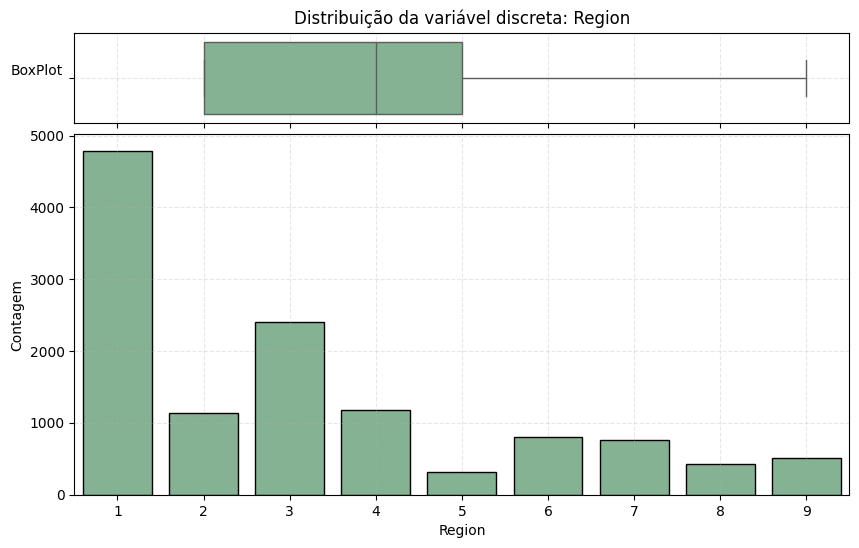

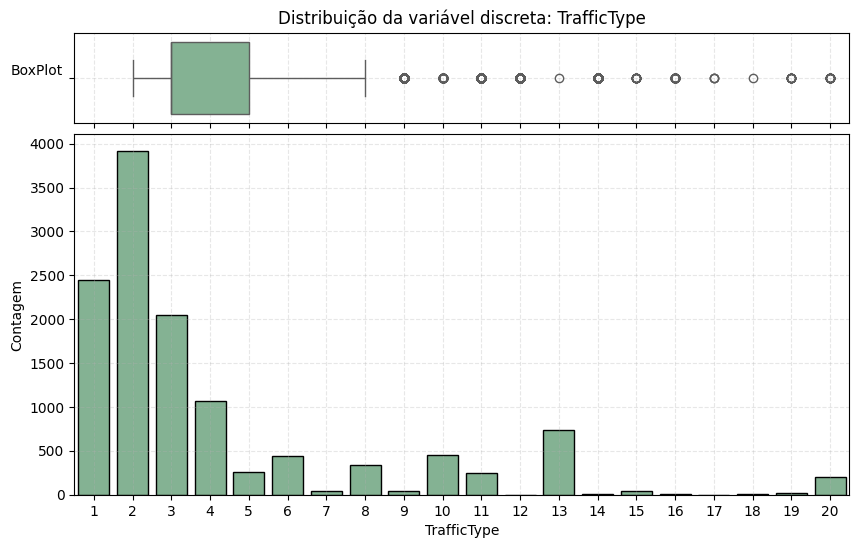

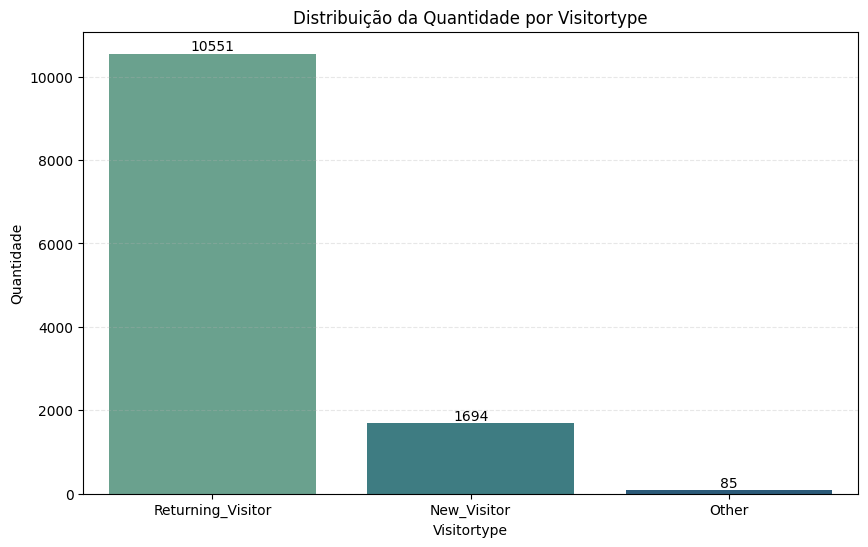

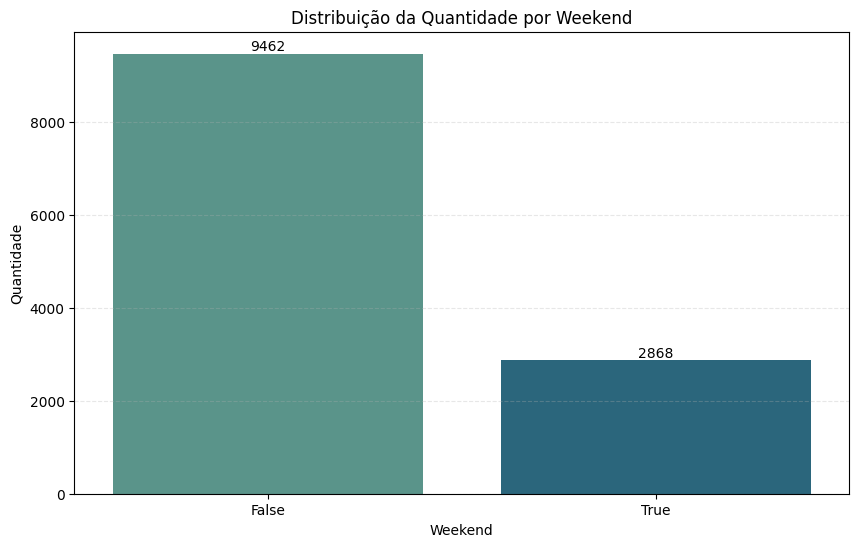

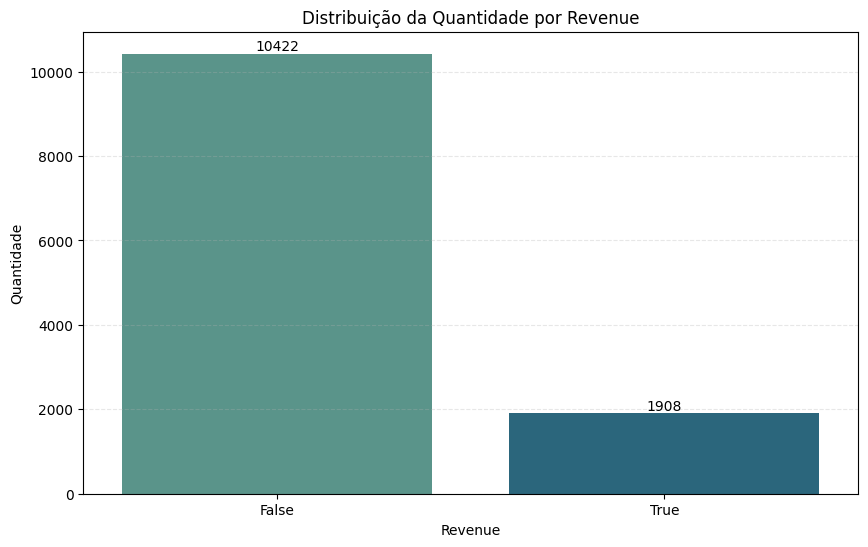

In [197]:
variaveis = df.columns.to_list()
for var in variaveis:
    distribuicao(df, var)

Muitas variáveis apresentam característica de decrescimento logarítmico, aquelas com um acúmulo de valores próximos do zero e com a cauda longa. Porém como a técnica utilizada nessa atividade não envolve K-Means ou outro tipo de modelagem em que os dados necessitam estar distribuidos o mais próximo de uma normal para obter melhores resultados, não será necessário realizar algum tratamento sobre elas.

In [198]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

O DataFrame não apresenta nenhum valor nulo.

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [199]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Seleção das variáveis que descrevem o padrão de navegação na sessão e das que indiquem característica da data:

As variáveis selecionadas para o agrupamento foram:

- Administrative
- Administrative_Duration
- Informational
- Informational_Duration
- ProductRelated
- ProductRelated_Duration
- BounceRates
- ExitRates
- PageValues


In [244]:
var_select = df.iloc[:, :9].columns.to_list() + ['SpecialDay', 'Month', 'Weekend']

In [245]:
df_select = df[var_select].copy()
print(df_select.shape)
df_select

(12330, 12)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Weekend
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,True
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,True
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,True
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,False


Tratamento das variáveis categóricas e booleanas:

In [246]:
month_map = {
    'Feb': 2, 'Mar': 3, 'May': 5, 'June': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df_select['Month'] = df_select['Month'].map(month_map)
df_select['Weekend'] = df_select['Weekend'].astype(int)

In [247]:
df_select.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
Weekend                    0
dtype: int64

O DataFrame não possui valores nulos.

In [248]:
df_select.dropna(inplace=True)
df_select.shape

(12330, 12)

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

Tratamento para utilizar na matriz de gower:

In [249]:
vars_cat = [True if x in {'Month', 'Weekend'} else False for x in df_select.columns]

In [250]:
distancia_gower = gower_matrix(df_select, cat_features=vars_cat)

In [251]:
distancia_gower[:5, :5]

array([[0.        , 0.12520157, 0.        , 0.08762167, 0.22271456],
       [0.12520157, 0.        , 0.12520157, 0.03757989, 0.11417966],
       [0.        , 0.12520157, 0.        , 0.08762167, 0.22271456],
       [0.08762167, 0.03757989, 0.08762167, 0.        , 0.13509288],
       [0.22271456, 0.11417966, 0.22271456, 0.13509288, 0.        ]],
      dtype=float32)

In [252]:
gdv = squareform(distancia_gower,force='tovector')

In [253]:
gdv.shape

(76008285,)

In [254]:
Z = linkage(gdv, method='complete')

In [255]:
cluster_3 = fcluster(Z, 3, criterion='maxclust')
cluster_4 = fcluster(Z, 4, criterion='maxclust')

df_cluster_3 = df_select.copy()
df_cluster_4 = df_select.copy()

df_cluster_3['grupo'] = cluster_3
df_cluster_4['grupo'] = cluster_4

In [256]:
df_cluster_3.grupo.value_counts().sort_index()

grupo
1       3
2    8518
3    3809
Name: count, dtype: int64

In [257]:
df_cluster_4.grupo.value_counts().sort_index()

grupo
1       3
2    8518
3    2617
4    1192
Name: count, dtype: int64

In [258]:
variaveis = ['SpecialDay', 'Weekend']
media_3 = round(df_cluster_3.groupby('grupo')[variaveis].mean(), 2)
moda_3 = df_cluster_3.groupby('grupo')['Month'].agg(lambda x: x.mode().iloc[0])

resumo_3 = pd.concat([media_3, moda_3], axis=1)
resumo_3.T

grupo,1,2,3
SpecialDay,0.00,0.00,0.20
Weekend,0.33,0.28,0.12
Month,12.00,11.00,5.00


In [259]:
media_4 = round(df_cluster_4.groupby('grupo')[variaveis].mean(), 2)
moda_4 = df_cluster_4.groupby('grupo')['Month'].agg(lambda x: x.mode().iloc[0])

resumo_4 = pd.concat([media_4, moda_4], axis=1)
resumo_4.T

grupo,1,2,3,4
SpecialDay,0.00,0.00,0.26,0.07
Weekend,0.33,0.28,0.06,0.25
Month,12.00,11.00,5.00,5.00


O agrupamento com 4 grupos apresentam valores para o grupo 3 e 4. Portanto a quantidade a ser utilizada será de 3 grupos.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

Adicionando os grupos ao DataFrame original:

In [260]:
x = df_cluster_3['grupo']
df_final = pd.concat([df, x], axis=1)
df_final

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,grupo
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,3
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,3
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,3
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,3
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False,2
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False,2
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False,2
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False,2


Avaliação de acordo com a variável `Revenue`, para entender qual grupo está mais propenso a realizar compra:

In [261]:
proporcao = round(pd.crosstab(df_final['grupo'], df_final['Revenue'], normalize='index') * 100, 2)
proporcao.rename(columns={False: 'Não Comprou (%)', True: 'Comprou (%)'})

Revenue,Não Comprou (%),Comprou (%)
grupo,,
1,100.00,0.00
2,81.09,18.91
3,92.20,7.80


<Figure size 1000x600 with 0 Axes>

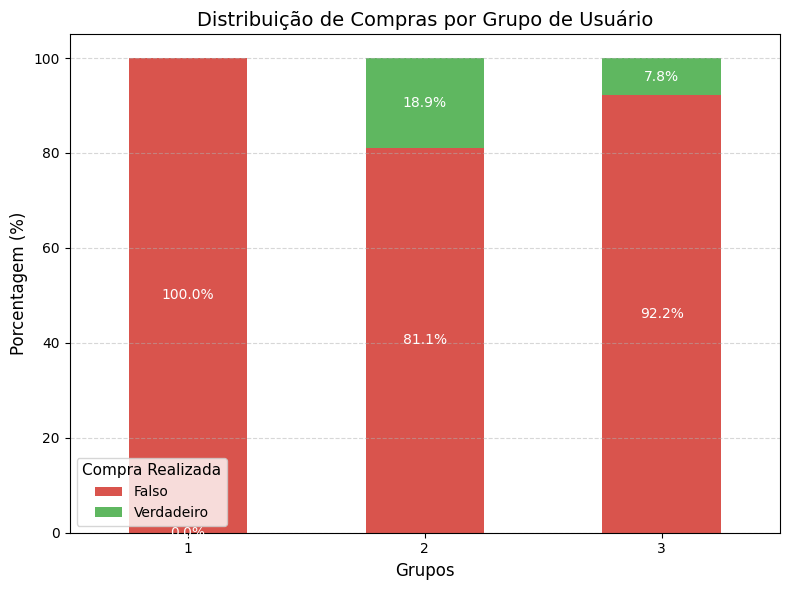

In [262]:
proporcao.rename(columns={True: 'Verdadeiro', False: 'Falso'}, inplace=True)
plt.figure(figsize=(10,6))
ax = proporcao.plot(kind='bar',
                    stacked=True,
                    color=['#D9544D', '#5FB760'],
                    figsize=(8,6),
                    edgecolor=None)

plt.title('Distribuição de Compras por Grupo de Usuário', fontsize=14)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xlabel('Grupos', fontsize=12)
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='white')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Compra Realizada', title_fontsize=11, loc='lower left')
plt.tight_layout()

plt.show()

In [263]:
g = df_final[['BounceRates', 'ExitRates', 'PageValues', 'Revenue', 'grupo']].groupby('grupo').mean(numeric_only=True)
g['Revenue'] = round(g['Revenue']*100, 2)

In [264]:
variaveis_sum = ['Administrative', 'Informational', 'ProductRelated']

variaveis_mean = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']

agrupado = df_final.groupby('grupo')

soma = agrupado[variaveis_sum].sum().rename(columns=lambda x: x + '_sum')
media = round(agrupado[variaveis_mean].mean(), 2).rename(columns=lambda x: x + '_mean')

resumo = pd.concat([resumo_3, soma, media, g], axis=1)
resumo.T

grupo,1,2,3
SpecialDay,0.000000,0.000000,0.200000
Weekend,0.330000,0.280000,0.120000
Month,12.000000,11.000000,5.000000
Administrative_sum,37.000000,23093.000000,5416.000000
Informational_sum,43.000000,5007.000000,1159.000000
ProductRelated_sum,1497.000000,310722.000000,79030.000000
Administrative_Duration_mean,2895.110000,93.620000,49.980000
Informational_Duration_mean,2182.990000,40.720000,18.820000
ProductRelated_Duration_mean,45705.070000,1372.960000,761.150000
BounceRates,0.003644,0.008091,0.053739


### Considerações finais:

---

#### Grupo 1:

- Valor estimado por visita muito baixo (PageValues: 0.25), quase nenhuma intenção de compra. 
- Nenhuma conversão registrada.
- Navegação de baixa duração e poucas interações em todas as páginas.
- Mês de maior acesso é Dezembro.
- Possui a maior presença dos acessos aos finais de semana, ainda sim com um valor baixo.
- Sem presença em dias especiais.

A taxa de rejeição e saída são muito baixas, indicando que os usuários acessam poucas páginas e logo saem. Não há registros de conversão realizada. Representa visitantes casuais ou desinteressados, navegando de forma passiva.

--- 

#### Grupo 2: 

- Valor médio por visita elevado (PageValues: 6.82), o mais alto entre os 3 grupos, alta propensão de compra.
- Maior taxa de conversão entre os grupos (Revenue: 18.91%).
- Navegação com alta interação com páginas de produto.
- Mês de maior acesso é Novembro.
- Possui a segunda maior presença aos finais de semana, mas com um valor pequeno.
- Sem presença em dias especiais.

Os usuários exploram melhor o site, têm baixa taxa de rejeição e contribuem significativamente para as conversões. Trata-se do grupo com maior potencial comercial.

---

#### Grupo 3:

- Valor médio por visita intermediário (PageValues: 3.81), possível intenção de compra.
- Possui uma pequena taxa de conversão (Revenue: 7.8%).
- Navegação com interesse em páginas de produtos, mas com duração moderada.
- Mês de maior acesso é Maio.
- Presença irrelevante aos finais de semana.
- Grupo com a maior presença em dias especiais.

As taxas de rejeição e saída são mais altas, podendo sugerir que os usuários interagem com o conteúdo, mas desistem antes de converter. Esse grupo demonstra interesse, mas encontra obstáculos.

---